In [1]:
!pip install prophet

import prophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

## Mean Absolute Percentage Error for evaluation metric
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Data¶
The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region.

In [3]:
pjme = pd.read_csv('Hourly Energy Consumption/PJME_hourly.csv',
                   index_col=[0],
                  parse_dates=[0])
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<Axes: title={'center': 'PJME MW'}, xlabel='Datetime'>

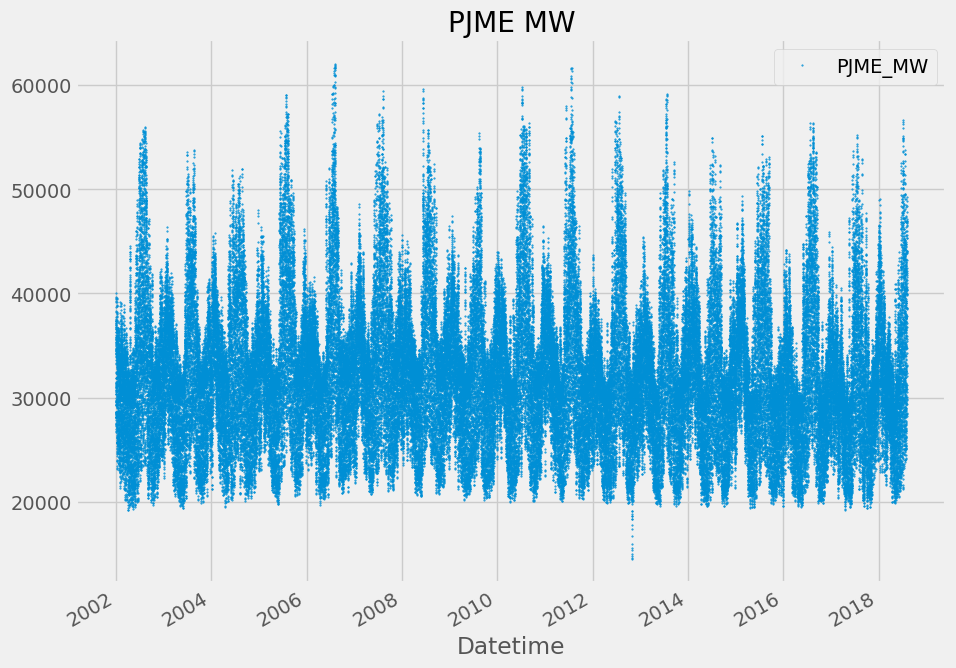

In [4]:
color_pal = sns.color_palette()
pjme.plot(style='.',
          figsize=(10,8),
          ms = 1,
          color=color_pal[0],
          title = "PJME MW"
          )

## Time Series Features

In [5]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

In [6]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0


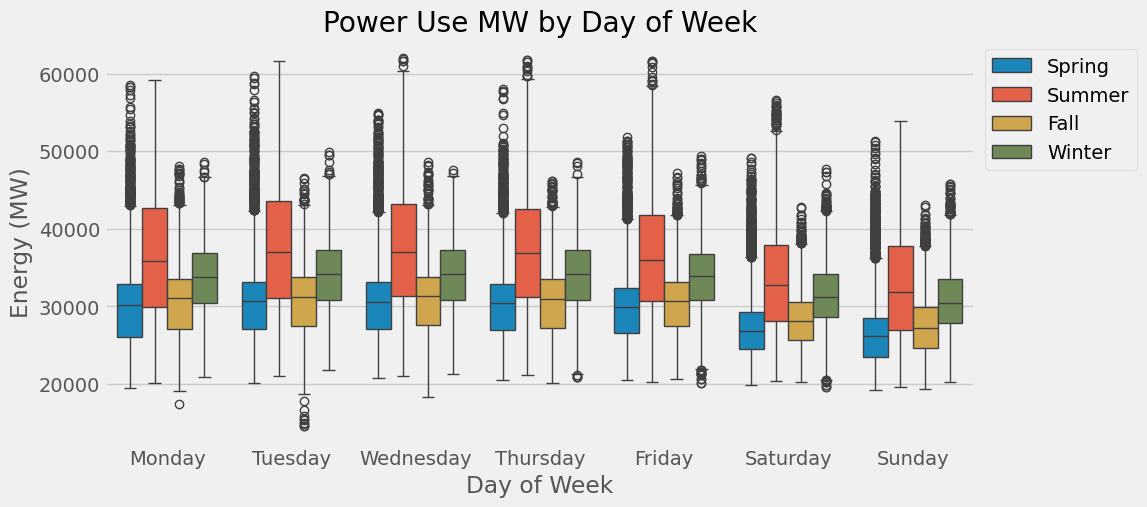

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## Forecasting

## Train Test Split

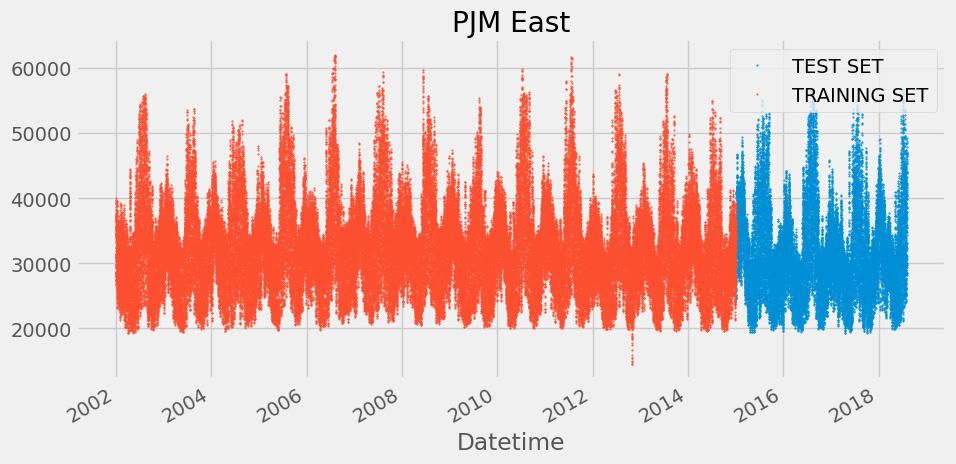

In [8]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

## Simple Prophet Model
Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

Datetime column named: ds

target : y

In [9]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [10]:
pjme_train_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [11]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpceiiequb/ihv2bidb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpceiiequb/a0d_ob8j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39876', 'data', 'file=/tmp/tmpceiiequb/ihv2bidb.json', 'init=/tmp/tmpceiiequb/a0d_ob8j.json', 'output', 'file=/tmp/tmpceiiequb/prophet_modelnzq17mxj/prophet_model-20241229100559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:05:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:07:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 11.9 s, sys: 486 ms, total: 12.4 s
Wall time: 1min 25s


In [12]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [13]:
pjme_test_fcst.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31210.530967,24118.995856,32781.598554,31210.530967,31210.530967,-2893.742472,-2893.742472,-2893.742472,-4430.272423,...,1281.328732,1281.328732,1281.328732,255.201219,255.201219,255.201219,0.0,0.0,0.0,28316.788495
1,2015-01-01 02:00:00,31210.494154,22558.008920,31495.519572,31210.494154,31210.494154,-4398.239425,-4398.239425,-4398.239425,-5927.272577,...,1272.574102,1272.574102,1272.574102,256.459050,256.459050,256.459050,0.0,0.0,0.0,26812.254729
2,2015-01-01 03:00:00,31210.457342,21478.029893,30579.454116,31210.457342,31210.457342,-5269.974485,-5269.974485,-5269.974485,-6790.346308,...,1262.613389,1262.613389,1262.613389,257.758434,257.758434,257.758434,0.0,0.0,0.0,25940.482857
3,2015-01-01 04:00:00,31210.420529,21148.471667,30431.178112,31210.420529,31210.420529,-5411.456410,-5411.456410,-5411.456410,-6922.126021,...,1251.570211,1251.570211,1251.570211,259.099400,259.099400,259.099400,0.0,0.0,0.0,25798.964119
4,2015-01-01 05:00:00,31210.383716,22023.939775,30875.279509,31210.383716,31210.383716,-4737.018106,-4737.018106,-4737.018106,-6237.080479,...,1239.580401,1239.580401,1239.580401,260.481971,260.481971,260.481971,0.0,0.0,0.0,26473.365610


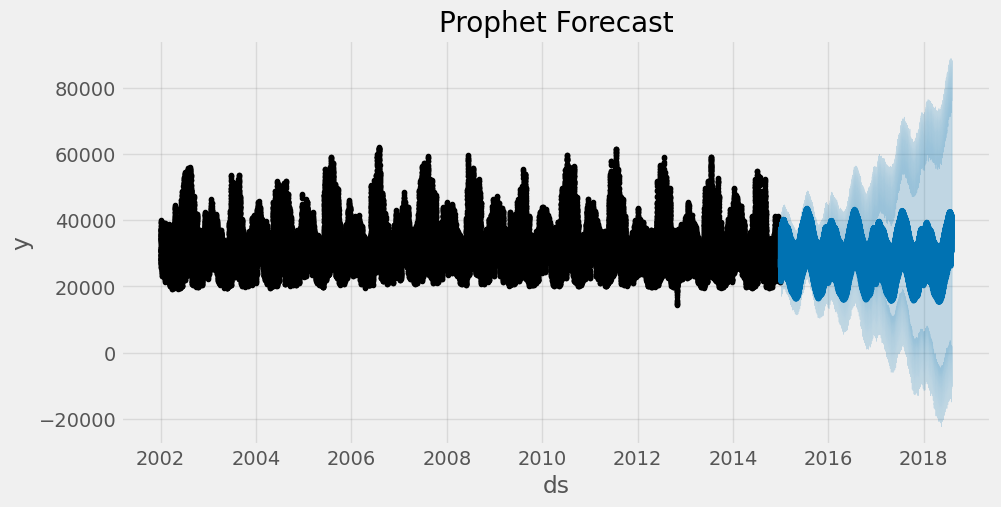

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

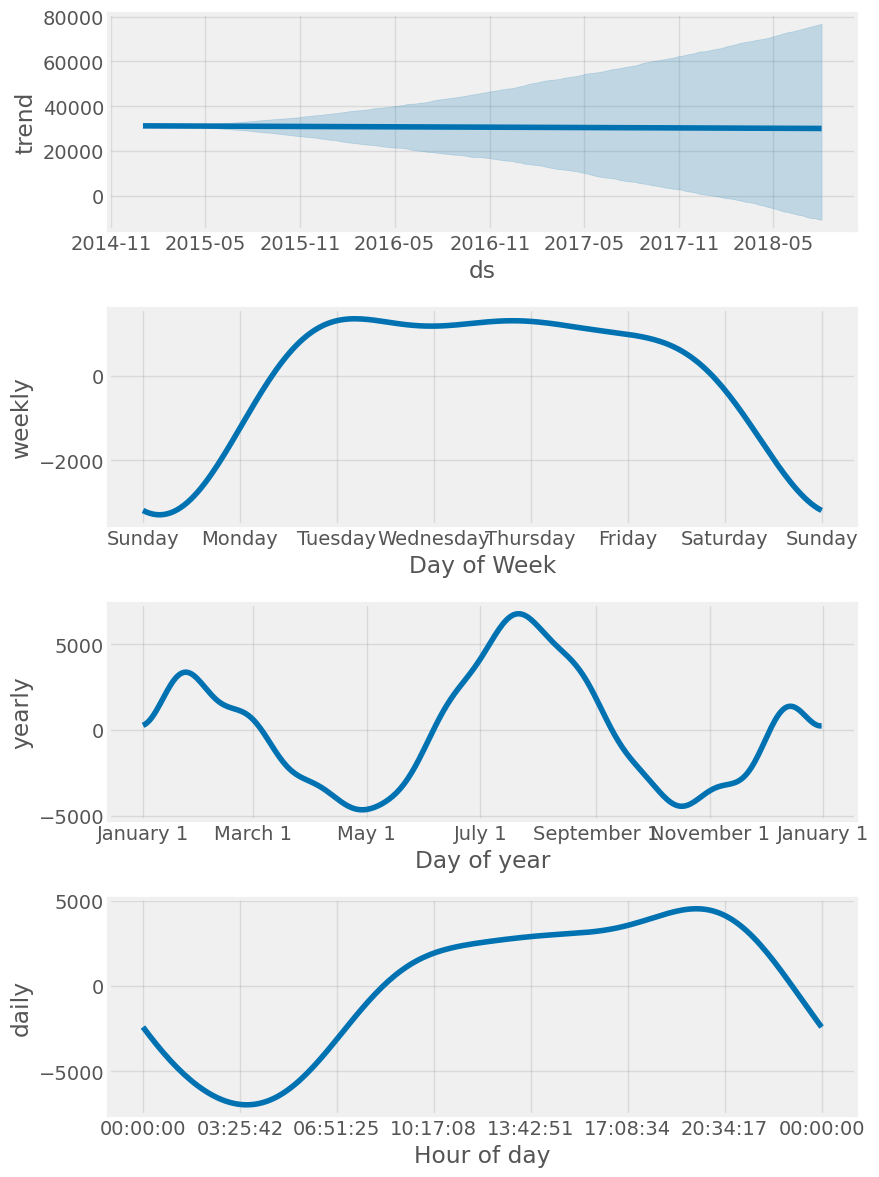

In [15]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

## Compare Forecast to Actuals

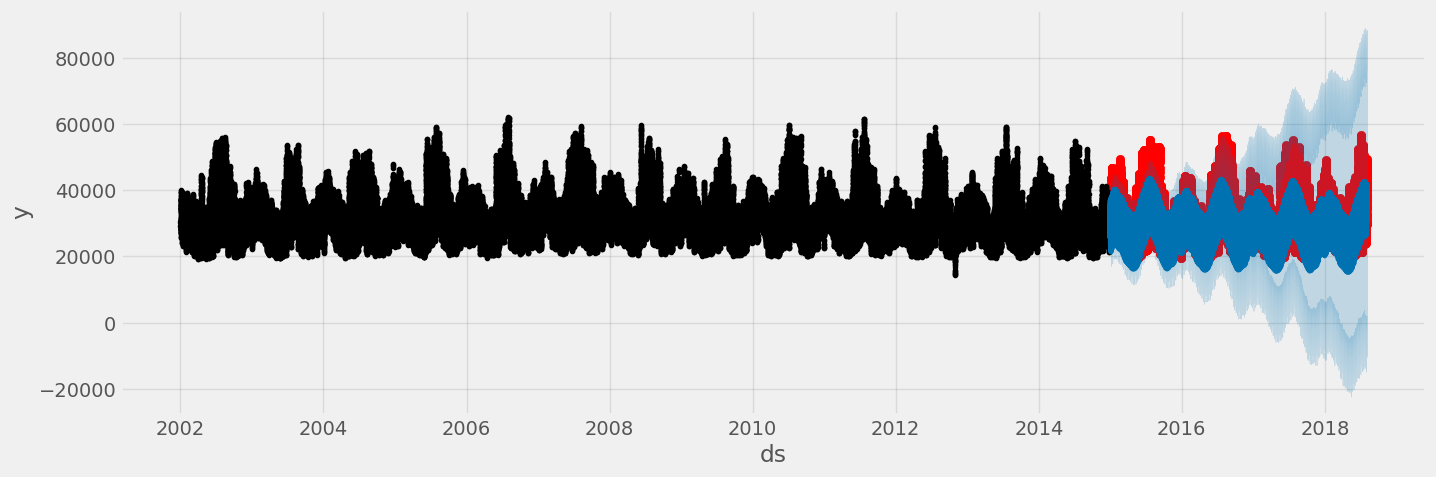

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

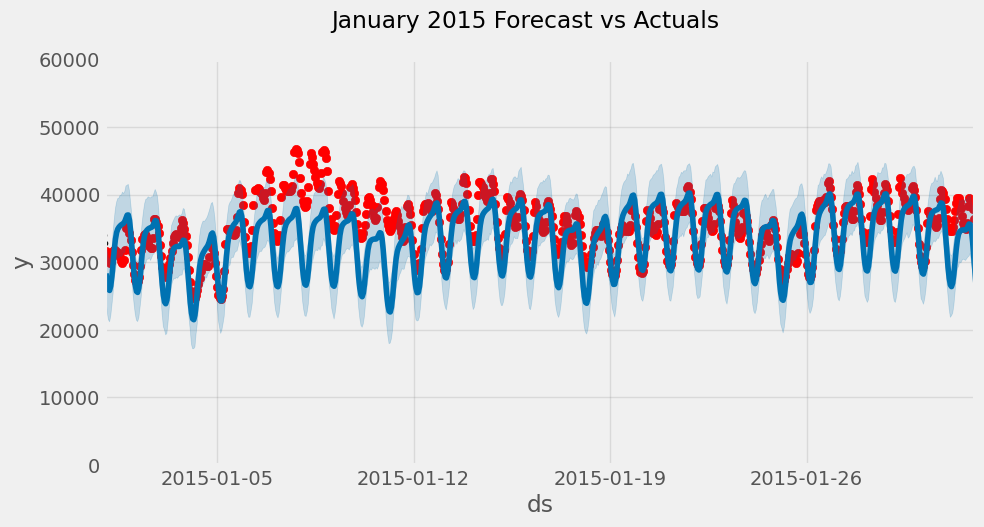

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.Timestamp('01-01-2015'), upper=pd.Timestamp('02-01-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

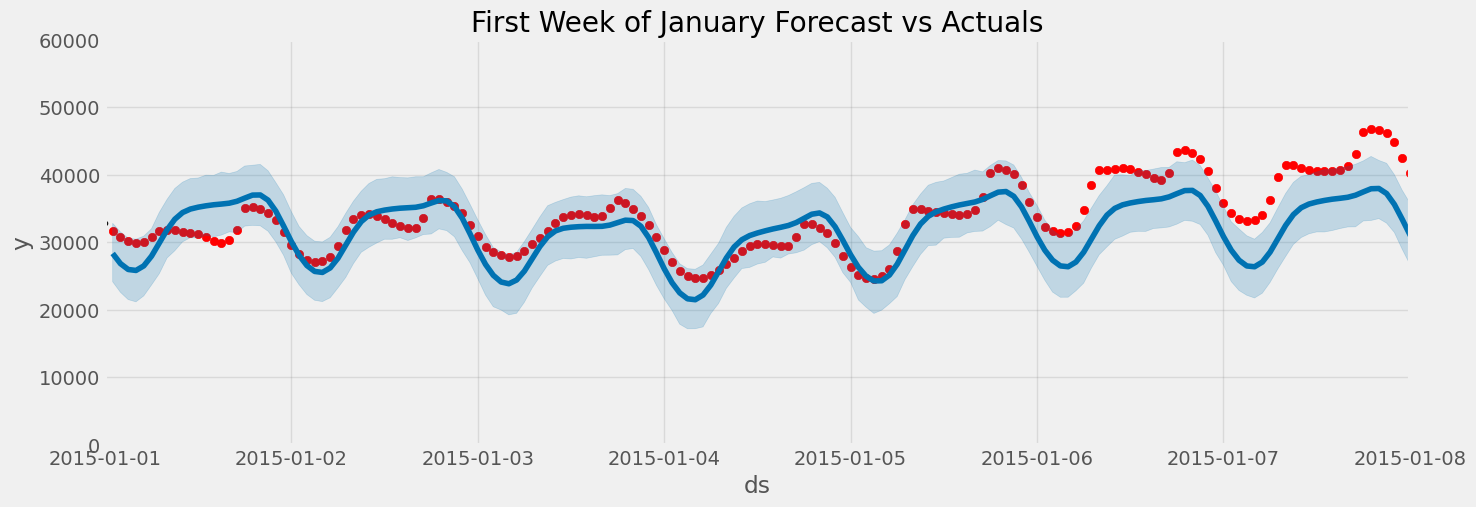

In [19]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=pd.Timestamp('01-01-2015'), upper=pd.Timestamp('01-08-2015'))
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

## Evaluate the model with Error Metrics¶


In [20]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6616.966074225221

In [21]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5181.911537928106

In [22]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.512003880182647

## Adding Holidays¶
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [24]:
holiday_df

,ds,holiday
0,2002-01-21,"Birthday of Martin Luther King, Jr."
1,2002-02-18,Washington's Birthday
2,2002-05-27,Memorial Day
3,2002-07-04,Independence Day
4,2002-09-02,Labor Day
...,...,...
159,2018-01-01,New Year's Day
160,2018-01-15,"Birthday of Martin Luther King, Jr."
161,2018-02-19,Washington's Birthday
162,2018-05-28,Memorial Day


In [25]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpceiiequb/5g3y8j_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpceiiequb/jxx_35wj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23497', 'data', 'file=/tmp/tmpceiiequb/5g3y8j_x.json', 'init=/tmp/tmpceiiequb/jxx_35wj.json', 'output', 'file=/tmp/tmpceiiequb/prophet_modelsk0__7uq/prophet_model-20241229102532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:25:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:27:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 12.5 s, sys: 453 ms, total: 12.9 s
Wall time: 2min 15s


In [26]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

In [30]:
pjme_test_fcst_with_hols.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31244.605359,21232.084377,30405.200847,31244.605359,31244.605359,0.0,0.0,0.0,0.0,...,1324.563260,1324.563260,1324.563260,674.238719,674.238719,674.238719,0.0,0.0,0.0,25567.271675
1,2015-01-01 02:00:00,31244.565753,19616.012511,28483.488191,31244.565753,31244.565753,0.0,0.0,0.0,0.0,...,1318.789016,1318.789016,1318.789016,675.204193,675.204193,675.204193,0.0,0.0,0.0,24065.351481
2,2015-01-01 03:00:00,31244.526148,18854.005616,27853.959752,31244.526148,31244.526148,0.0,0.0,0.0,0.0,...,1311.473104,1311.473104,1311.473104,676.203430,676.203430,676.203430,0.0,0.0,0.0,23195.828972
3,2015-01-01 04:00:00,31244.486542,18275.870140,27415.184675,31244.486542,31244.486542,0.0,0.0,0.0,0.0,...,1302.726308,1302.726308,1302.726308,677.236467,677.236467,677.236467,0.0,0.0,0.0,23056.212620
4,2015-01-01 05:00:00,31244.446936,19427.962261,28194.887060,31244.446936,31244.446936,0.0,0.0,0.0,0.0,...,1292.675293,1292.675293,1292.675293,678.303342,678.303342,678.303342,0.0,0.0,0.0,23732.192245


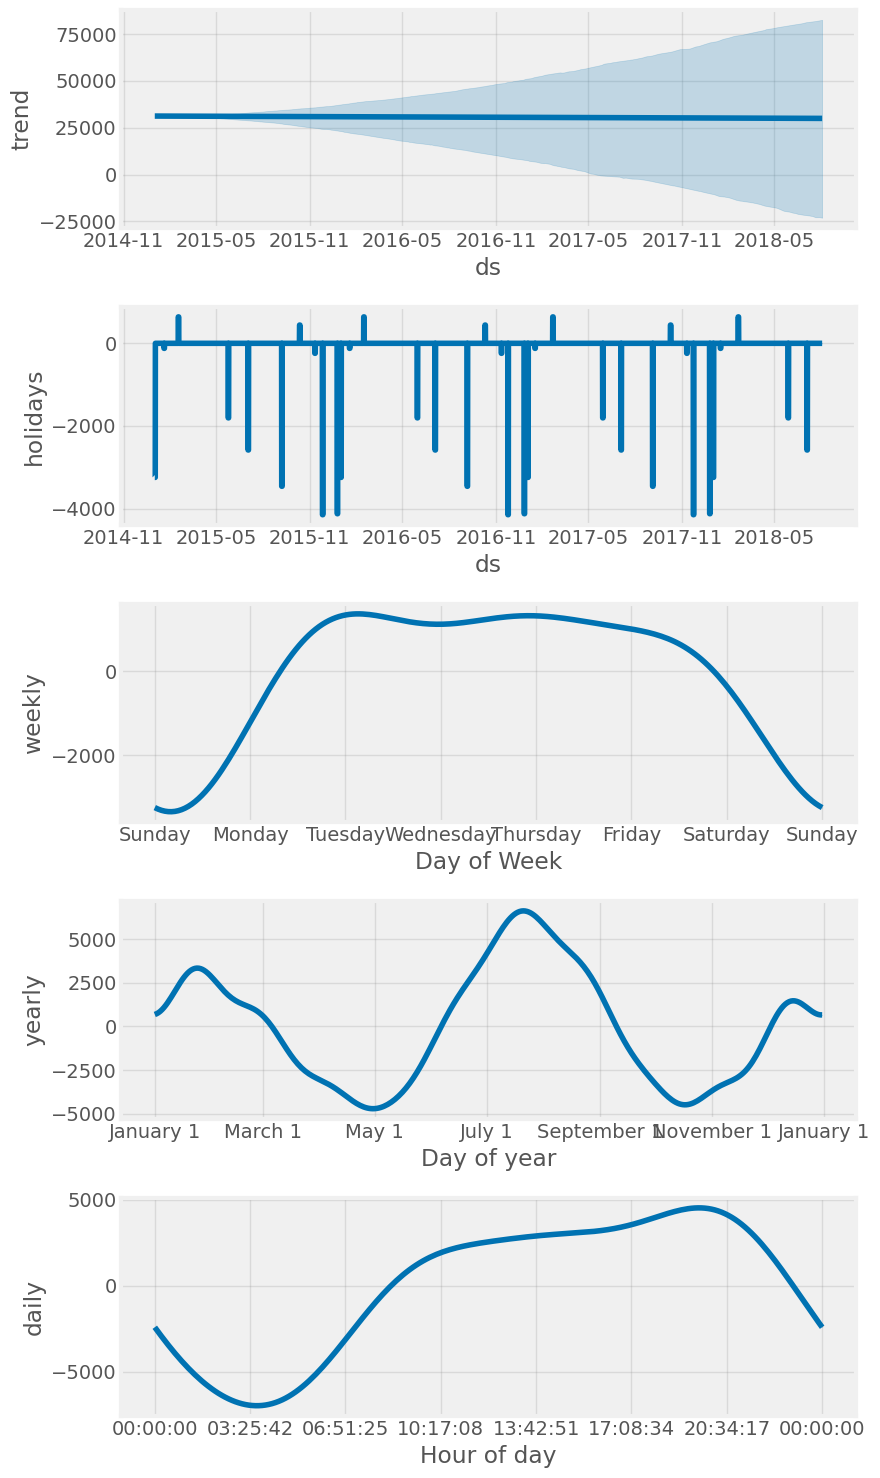

In [27]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

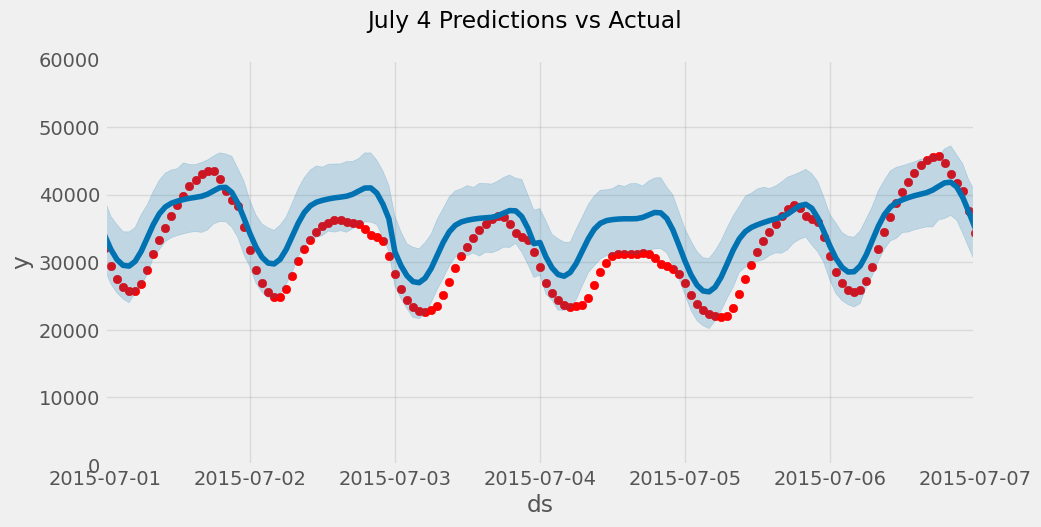

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower=pd.Timestamp('07-01-2015'),
              upper=pd.Timestamp('07-07-2015'))
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

In [31]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

6639.587205626055

In [32]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5201.46462763833

In [33]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.558807523531467

## Predict into the Future¶
We can use the built in make_future_dataframe method to build our future dataframe and make predictions.

In [34]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [36]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31244.605359,21173.718875,30074.006615,31244.605359,31244.605359,0.0,0.0,0.0,0.0,...,1324.563260,1324.563260,1324.563260,674.238719,674.238719,674.238719,0.0,0.0,0.0,25567.271675
1,2015-01-01 02:00:00,31244.565753,19648.642283,28631.638139,31244.565753,31244.565753,0.0,0.0,0.0,0.0,...,1318.789016,1318.789016,1318.789016,675.204193,675.204193,675.204193,0.0,0.0,0.0,24065.351481
2,2015-01-01 03:00:00,31244.526148,18849.202524,27732.593836,31244.526148,31244.526148,0.0,0.0,0.0,0.0,...,1311.473104,1311.473104,1311.473104,676.203430,676.203430,676.203430,0.0,0.0,0.0,23195.828972
3,2015-01-01 04:00:00,31244.486542,18638.507872,27669.118914,31244.486542,31244.486542,0.0,0.0,0.0,0.0,...,1302.726308,1302.726308,1302.726308,677.236467,677.236467,677.236467,0.0,0.0,0.0,23056.212620
4,2015-01-01 05:00:00,31244.446936,19307.819764,28047.704312,31244.446936,31244.446936,0.0,0.0,0.0,0.0,...,1292.675293,1292.675293,1292.675293,678.303342,678.303342,678.303342,0.0,0.0,0.0,23732.192245


In [35]:
forecast[['ds','yhat']].head()


,ds,yhat
0,2015-01-01 01:00:00,25567.271675
1,2015-01-01 02:00:00,24065.351481
2,2015-01-01 03:00:00,23195.828972
3,2015-01-01 04:00:00,23056.212620
4,2015-01-01 05:00:00,23732.192245
